### Maternal Health Risk Detection

In this notebook, we evaluate various machine learning models for **Maternal Health Risk Detection** using the dataset available on Kaggle:  
[Maternal Health Risk Detection Dataset](https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data)

> Dataset source: https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data

We will experiment with several machine learning algorithms, including but not limited to:

1. `DecisionTreeClassifier`  
2. `SVC`  
3. `RandomForestClassifier`  
4. `LogisticRegression`  
5. `KNeighborsClassifier`  

In the following code cell, we will install all the required packages for this notebook.


In [1]:
!pip install pigmenta helperfns kaggle -q

### 📦 Import of Modules

In the following code cell, we will import all the necessary packages 📚 that will be used throughout this notebook 💻.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
import os
import json
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import xgboost as xgb
from pigmenta import PALETTES


warnings.filterwarnings("ignore")
print("pandas:", pd.__version__)
print("sklearn: ", sklearn.__version__)
print("numpy:", np.__version__)
print("xgb:", xgb.__version__)

pandas: 2.2.2
sklearn:  1.6.1
numpy: 2.0.2
xgb: 3.1.0


### 🌱 Seed

Next, we will set the seed for all random operations 🔢 to ensure the reproducibility of results in this notebook 📊.


In [3]:
SEED = 23

np.random.seed(SEED)
random.seed(SEED)

### 📊 Data

In the following code cell, we will define the path to where the dataset is located 📁.

We'll use the **Kaggle API** 🚀 to download the dataset directly from Kaggle:

> https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data


In [4]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download csafrit2/maternal-health-risk-data --unzip

path = "Maternal Health Risk Data Set.csv"

Dataset URL: https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data
License(s): other
  0% 0.00/3.77k [00:00<?, ?B/s]
100% 3.77k/3.77k [00:00<00:00, 13.3MB/s]


### 🧾 Load Data

Next, we will read the dataset into a **Pandas DataFrame** 🐼 for exploration and analysis 🔍.


In [5]:
data = pd.read_csv(path)
data.head(2)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk


In the following code cell we are going to check the original size of the dataset.

In [6]:
print(f"The size of the dataset: {len(data)}")

The size of the dataset: 1014


### 🧹 Data Cleaning

In the following code cell, we will drop all `NaN` values 🚫 that might exist in the columns of this dataset to ensure data quality and consistency ✅.


In [7]:
if any(data.isna().any()):
    data.dropna(inplace=True)

In the following code cell we are going to check the size of the dataset after removing `NaN` rows.

In [8]:
print(f"The size of the dataset after removing null values: {len(data)}")

The size of the dataset after removing null values: 1014


### 📈 Data Insights

In this section of the notebook, we will explore key insights 🔍 from the dataset to better understand its structure and characteristics.

We'll start by examining the **distribution of labels** 🏷️ in the dataset to see how the classes are represented.


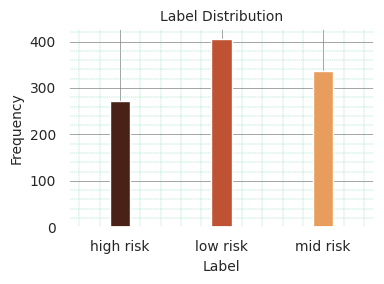

In [9]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=data, x="RiskLevel", palette=PALETTES.fall, width=0.2)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title("Label Distribution", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Handling Class Imbalance

The dataset is **not balanced**, meaning some label classes have significantly more examples than others ⚠️.  
To ensure that **accuracy remains a reliable performance metric**, we will **downsample the majority classes** so that each label class has approximately the same number of samples as the minority class *(Ngwenya and Garidzira, 2025)*.

This approach helps prevent the model from becoming biased toward the majority classes 🧠 and allows for a fairer evaluation of model performance ⚙️.

**Reference:**  
Ngwenya, S. and Garidzira, T.C., 2025. *Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation.* The Indonesian Journal of Computer Science, 14(4).


In [10]:
new_dataframe = data.copy()
min_class_count = new_dataframe['RiskLevel'].value_counts().min()
downsampled_list = []
for label in new_dataframe['RiskLevel'].unique():
    class_df = new_dataframe[new_dataframe['RiskLevel'] == label]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

### 📊 Visualizing Balanced Dataset

In the following code cell, we will visualize the distribution of the **balanced dataset** using a **pie chart** 🥧.  
This helps us confirm that all label classes now have approximately equal representation after the downsampling process ✅.

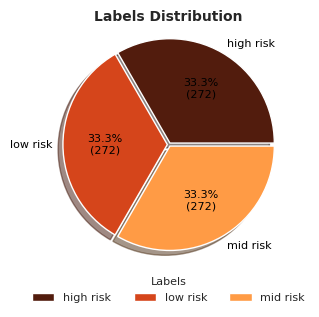

In [11]:
samples = dict(balanced_df.RiskLevel.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8},
    radius=.6, colors=PALETTES.fall,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Labels Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Labels", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

### 📉 Visualizing Feature Distribution

In the following code cell, we will plot **histograms** 📊 to visualize the distribution of numerical features in the dataset.  
This helps us understand the spread and patterns of the data for each feature 🔍.

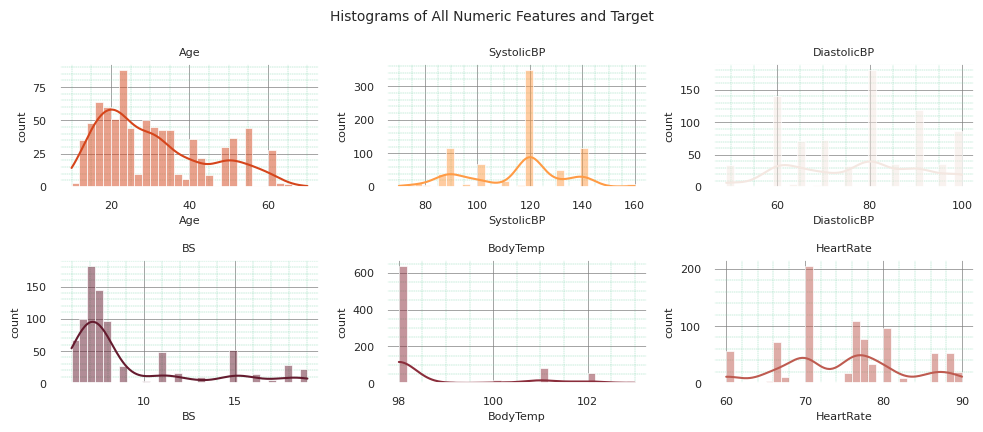

In [12]:
numeric_features = balanced_df.columns[:-1]
plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(balanced_df[col], kde=True, bins=30, color=PALETTES.fall[i])
    plt.title(col, fontsize=8)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("count", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.suptitle("Histograms of All Numeric Features and Target", fontsize=10)
plt.tight_layout()
plt.show()

### 🔥 Correlation Heatmap

The following code cell displays a **correlation heatmap** 🌡️ between the numerical variables in the dataset.  

This visualization helps identify relationships and dependencies between features 📊.


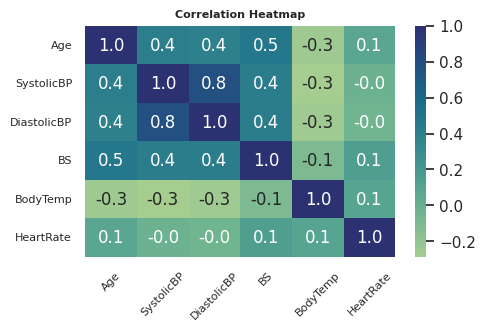

In [13]:
plt.figure(figsize=(5, 3))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="crest", fmt=".1f")
plt.title("Correlation Heatmap", fontsize=8, weight="bold")
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.show()

### ✂️ Splitting the Data

In the following code cell, we will split the dataset into **two sets**: `train` 🏋️‍♂️ and `test` 🧪.  
This allows us to train the model on one set and evaluate its performance on the other.


In [14]:
train, test = train_test_split(
    balanced_df, test_size=0.15, random_state=SEED
)

### 🔍 Checking Data Distribution

Next, we will examine the **distribution of data** in each set 📊 to ensure that the splitting process preserved the class balance ⚖️.


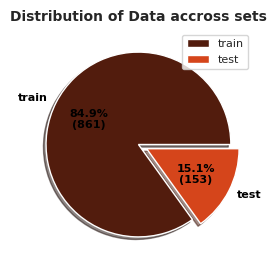

In [15]:
dist_sets = {'train': len(train), 'test': len(test)}
def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(3, 3))
plt.title("Distribution of Data accross sets", fontsize=10, weight="bold")
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(data)),
    textprops={'color': 'black', 'fontsize': 8, "weight": 'bold'}, radius=1, explode=[.0, .1],
    colors=PALETTES.fall, shadow=True,
)
plt.legend(fontsize=8)
plt.show()

### 🏷️ Extracting Features and Labels

In the next code cell, we will extract **features** and **labels** from our dataset.  
The column `RiskLevel` will serve as our **target label** 🎯 for both the training and testing datasets.

After extracting the labels, we will apply the necessary **transformations** 🔄 to prepare them for model training.


In [16]:
y_train = train.RiskLevel.values
y_test = test.RiskLevel.values
y_train[:2]

array(['high risk', 'high risk'], dtype=object)

### 🔢 Encoding Labels

In the next code cell, we will define a **label encoder** 🏷️ to convert our categorical labels into **numerical values**.  
This transformation is necessary for machine learning models that require numeric input 🔄.


In [17]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = label_encoder.transform(y_test.reshape(-1, 1))

### ❌ Removing Target Column

In the following code cell, we will remove the `RiskLevel` column 🏷️ to isolate and extract our **features** for model training 💻.


In [18]:
train.drop(columns=["RiskLevel"], inplace=True)
test.drop(columns=["RiskLevel"], inplace=True)

train.head(2)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
270,28,83,60,8.0,101.0,86
63,55,140,95,19.0,98.0,77


### ⚙️ Feature Scaling

We will use **`StandardScaler`** ⚖️ to transform all the features in the training and test sets.  

This ensures that all features are on the same scale, which can improve the performance of many machine learning algorithms 📈.


In [19]:
categorical_colums = train.select_dtypes(include=['object']).columns
numerical_columns = train.select_dtypes(exclude=['object']).columns

scale_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])
ct = ColumnTransformer([
    ("scale pre-processing", scale_pipeline, numerical_columns)
])
train_features = ct.fit_transform(train)
test_features = ct.transform(test)
test_features[0]

array([-0.84134222,  0.29676279,  0.55014708, -0.33659349, -0.50332363,
       -1.970622  ])

### 🌟 Feature Importance

In the following code cell, we will create a function that uses the **`XGBRegressor`** 🐉 to compute the **importance of each feature** in predicting the `RiskLevel`.  

This helps us understand which features contribute most to the model's predictions 📊.


In [20]:
def get_feature_impotance(train_features, train_labels, test_features, test_labels):
    xgb_model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:linear',
        max_depth=3,
        learning_rate=0.01
    )
    xgb_model.fit(
        train_features, train_labels,
        eval_set=[(train_features, train_labels), (test_features, test_labels)],
        verbose=100
   )
    return xgb_model.feature_importances_

### 📌 Extracting Feature Importance

Next, we will retrieve the **feature importance values** 🏷️ for predicting `RiskLevel`.  
This array will show the contribution of each feature to the model’s predictions 🔍.


In [21]:
fi = get_feature_impotance(train_features, y_train, test_features, y_test)

[0]	validation_0-rmse:0.95154	validation_1-rmse:0.95176
[100]	validation_0-rmse:0.64690	validation_1-rmse:0.64063
[200]	validation_0-rmse:0.57822	validation_1-rmse:0.56371
[300]	validation_0-rmse:0.55593	validation_1-rmse:0.54090
[400]	validation_0-rmse:0.54354	validation_1-rmse:0.53063
[500]	validation_0-rmse:0.53084	validation_1-rmse:0.51857
[600]	validation_0-rmse:0.52047	validation_1-rmse:0.50510
[700]	validation_0-rmse:0.51160	validation_1-rmse:0.49769
[800]	validation_0-rmse:0.50404	validation_1-rmse:0.48982
[900]	validation_0-rmse:0.49720	validation_1-rmse:0.48219
[999]	validation_0-rmse:0.49059	validation_1-rmse:0.47634


### 🗂️ Preparing Data for Feature Importance Plot

Next, we will create a **DataFrame** 📊 to organize the feature importance values for `RiskLevel`.  
This DataFrame will be used to **visualize the contribution** of each feature in a plot 📈.


In [22]:
fi_df = pd.DataFrame(
    data=fi,
    index=train.columns,
    columns=['importance']
)
fi_df.head()

,importance
Age,0.069707
SystolicBP,0.479812
DiastolicBP,0.044221
BS,0.230611
BodyTemp,0.122117


### 📈 Visualizing Feature Importance

In the following code cell, we will **visualize how important each feature** is in predicting `RiskLevel` 🏷️.  
This helps us identify the most influential features for model predictions 🔍.


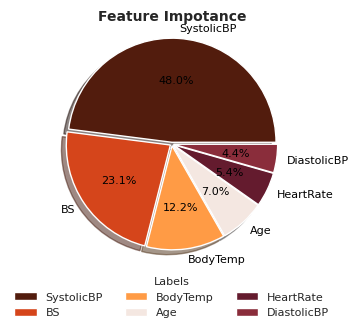

In [24]:
risk_fi_sorted = fi_df.sort_values('importance', ascending=False)
plt.figure(figsize=(3, 3))
plt.pie(
    risk_fi_sorted['importance'],
    labels=risk_fi_sorted.index,
    pctdistance=0.6, shadow=True,
    autopct='%1.1f%%',
    textprops={'color': 'black', 'fontsize': 8},
    radius=.6, colors=PALETTES.fall,
    explode=[.01 for _ in range(len(risk_fi_sorted))]
)
plt.axis('equal')
plt.title("Feature Impotance", fontsize=10, weight="bold")
plt.legend(
    labels=risk_fi_sorted.index,
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Labels", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

> We can see that `RiskLevel` is the most important feature in predicting the Maternal Health 🐟.

### 🤖 Model Selection

In the following code cell, we will train **5 regression algorithms** to determine which performs best for this task:

1. `Linear Regression (LR)` 📈  
2. `Decision Tree Regressor (DTR)` 🌳  
3. `Random Forest Regressor (RFR)` 🌲  
4. `Support Vector Regressor (SVR)` 🧩  
5. `K-Neighbors Regressor (KNR)` 👥  

We will evaluate these models to select the **best-performing algorithm** for predicting Maternal Health RiskLeval 🔍.


In [26]:
pipeline_lr = Pipeline([('lrr', LogisticRegression())])
pipeline_dt = Pipeline([ ('dtr', DecisionTreeClassifier())])
pipeline_rf = Pipeline([('rfr', RandomForestClassifier())])
pipeline_svr = Pipeline([('svr', SVC())])
pipeline_knn = Pipeline([('knnr', KNeighborsClassifier())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svr, pipeline_knn]
pipe_dict = {0: 'LR', 1: 'DTR', 2: 'RFR', 3: "SVR", 4: 'KNR'}

def get_scores(X_train, y_train, X_test, y_test):
    for pipe in pipelines:
        pipe.fit(X_train, y_train)

    scores = []
    for i, model in enumerate(pipelines):
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 =  f1_score(y_test, y_pred, average='weighted')
        rs = recall_score(y_test, y_pred, average='weighted')
        p = precision_score(y_test, y_pred, average='weighted')
        score = {
            'acc': acc, 'f1-score': f1, 'recall': rs,
            'precision': p,
            'classifier': pipe_dict[i]
        }
        scores.append(score)
    return scores

### 📊 Evaluating Model Performance

Next, we will obtain the **performance scores** for predicting `RiskLevel` 🏷️ and identify which algorithm performs the best ✅.  

This will help us choose the most suitable model for our regression task 🔍.


In [27]:
scores = get_scores(train_features, y_train, test_features, y_test)
scores

[{'acc': 0.6422764227642277,
  'f1-score': 0.6402097902097902,
  'recall': 0.6422764227642277,
  'precision': 0.641340194531684,
  'classifier': 'LR'},
 {'acc': 0.8292682926829268,
  'f1-score': 0.8275273745861983,
  'recall': 0.8292682926829268,
  'precision': 0.8290462767206953,
  'classifier': 'DTR'},
 {'acc': 0.8861788617886179,
  'f1-score': 0.8846024856376635,
  'recall': 0.8861788617886179,
  'precision': 0.8846325903450423,
  'classifier': 'RFR'},
 {'acc': 0.7154471544715447,
  'f1-score': 0.698007092866334,
  'recall': 0.7154471544715447,
  'precision': 0.7148148148148148,
  'classifier': 'SVR'},
 {'acc': 0.7154471544715447,
  'f1-score': 0.7094390872625407,
  'recall': 0.7154471544715447,
  'precision': 0.7077984817115253,
  'classifier': 'KNR'}]

In [28]:
scores_df  = pd.DataFrame(scores)
scores_df.head(10)

,acc,f1-score,recall,precision,classifier
0,0.642276,0.640210,0.642276,0.641340,LR
1,0.829268,0.827527,0.829268,0.829046,DTR
2,0.886179,0.884602,0.886179,0.884633,RFR
3,0.715447,0.698007,0.715447,0.714815,SVR
4,0.715447,0.709439,0.715447,0.707798,KNR


### 📈 Visualizing Classifier Performance

In the following code cell, we will **visualize the classifiers** along with the **metrics they achieved** 📊.  
This helps compare model performance at a glance and identify the best-performing algorithm ✅.


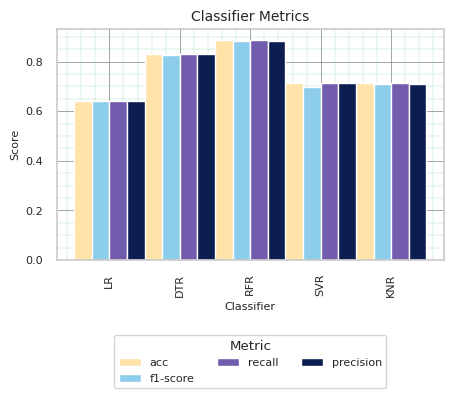

In [33]:
sns.set(font_scale=0.8)
sns.set_style("whitegrid")
scores_df.plot(
    x='classifier',
    kind='bar',
    stacked=False,
    fontsize=8,
    color=PALETTES.retro, width=1,
    legend=True,
    figsize=(5, 3)
)
plt.title('Classifier Metrics', fontsize=10)
plt.xlabel('Classifier', fontsize=8)
plt.ylabel('Score', fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=3,
    fontsize=8,
    title = "Metric"
)
plt.minorticks_on()
plt.show()